In [1]:
from pathlib import Path
import time
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import matplotlib.patches as patches
import pyarrow
import pyarrow.parquet as pq
# %load_ext watermark

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
'''Минуты в формат %M:%S'''
def min2format(minutes):
    minutes *= 60
    minutes = time.strftime("%M:%S", time.gmtime(minutes))
    return minutes

In [3]:
freqs = ['d', 'w', 'm', 'q'] # в конце имени файлов day, week, month, quarter
path2 = ''#Path(r'./../data/') # путь до файлов с датафреймами

# ЧТЕНИЕ файлов
# fname = path2 + 'run_ww_{}_{}.parquet'.format(2020, 'd')
# df = pd.read_parquet('run_ww_2020_d.parquet', engine='pyarrow')
df = pq.read_table('run_ww_2020_d.parquet')
df = df.to_pandas()

df2019 = pq.read_table('run_ww_2019_d.parquet')
df2019 = df2019.to_pandas()

# ОБЪЕДИНЕНИЕ 2019 и 2020 датафреймов
df = pd.concat([df, df2019], ignore_index=True)

In [4]:
df.head()

datetime  athlete  distance  duration gender age_group         country  \
0 2020-01-01        0   0.00000   0.00000      F   18 - 34   United States   
1 2020-01-01        1   5.72000  31.63333      M   35 - 54         Germany   
2 2020-01-01        2   0.00000   0.00000      M   35 - 54  United Kingdom   
3 2020-01-01        3   0.00000   0.00000      M   18 - 34  United Kingdom   
4 2020-01-01        4   8.07000  38.61667      M   35 - 54   United States   

                     major  
0             CHICAGO 2019  
1              BERLIN 2016  
2  LONDON 2018,LONDON 2019  
3              LONDON 2017  
4              BOSTON 2017

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26617172 entries, 0 to 26617171
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   athlete    int64         
 2   distance   float64       
 3   duration   float64       
 4   gender     object        
 5   age_group  object        
 6   country    object        
 7   major      object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.6+ GB


In [6]:
df.isnull().sum()

datetime          0
athlete           0
distance          0
duration          0
gender            0
age_group         0
country      240499
major             0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
# УДАЛЯЕМ колонку ненужную
df = df.drop(columns=['major'])

# УДАЛЯЕМ записи с меньше 2 километров
df = df[df['distance'] > 2]

# ДОБАВЛЯЕМ колонку с темпом, кол-во минут на 1 км
df['pace'] = df['duration'] / df['distance']

# УДАЛЯЕМ слишком быстрый и слишком медленный темп
df = df[(df['pace'] > 2.9) & (df['pace'] < 10)]

# УДАЛЯЕМ записи где дистанция > 50
df = df[(df['distance'] < 50)]

In [9]:
df[['distance', 'duration', 'pace']].describe()

distance      duration          pace
count 8952832.00000 8952832.00000 8952832.00000
mean       11.62942      62.55021       5.46027
std         6.67267      37.48085       0.95816
min         2.00900       5.85000       2.90005
25%         7.02000      38.96667       4.80898
50%        10.02000      54.03333       5.29101
75%        14.17000      74.00000       5.90000
max        49.99000     498.00000      10.00000

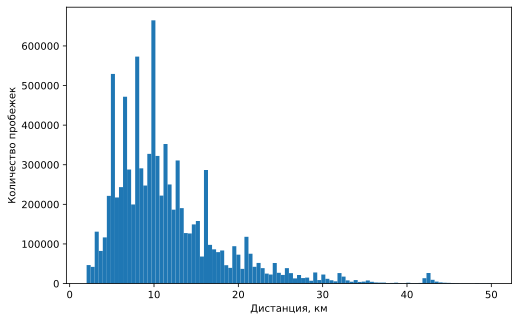

In [10]:
# какие дистанции наиболее популярны среди спортсменов
plt.hist(df['distance'], bins=100)
plt.xlabel('Дистанция, км')
plt.ylabel('Количество пробежек')
plt.show()

In [11]:
# ср. темп против дистанции: как меняется темп бега в зависимости от дистанции
sns.scatterplot(x='distance', y='pace', data=df[100000:150000])
plt.xlabel('Дистанция, км')
plt.ylabel('Средний темп, мин/км')
plt.show()

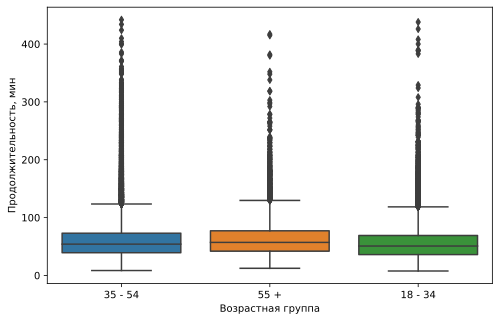

CPU times: user 519 ms, sys: 43.2 ms, total: 562 ms
Wall time: 447 ms


In [12]:
%%time
# продолжительности пробежки по возрастным группам
sns.boxplot(x='age_group', y='duration', data=df[:100000])
plt.xlabel('Возрастная группа')
plt.ylabel('Продолжительность, мин')
plt.show()

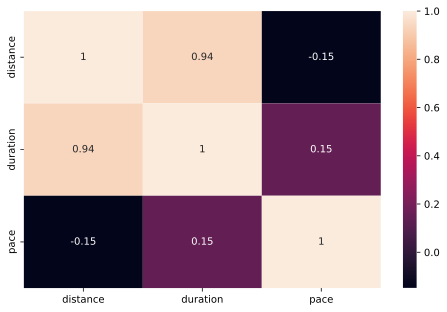

In [13]:
# какие признаки коррелируют
corr_matrix = df[['distance', 'duration', 'pace']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

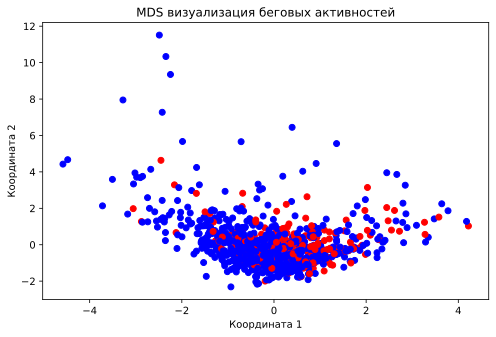

CPU times: user 52.5 s, sys: 7.6 s, total: 1min
Wall time: 37.3 s


In [14]:
%%time
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
X = df[:1000][['distance', 'duration', 'pace', 'gender', 'age_group']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns=['gender', 'age_group'], axis=1))

mds = MDS(n_components=2, dissimilarity='euclidean')
coordinates = mds.fit_transform(X_scaled)

# Визуализация данных на графике
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=X['gender'].map({'M': 'blue', 'F': 'red'}))
plt.title('MDS визуализация беговых активностей')
plt.xlabel('Координата 1')
plt.ylabel('Координата 2')
plt.show()

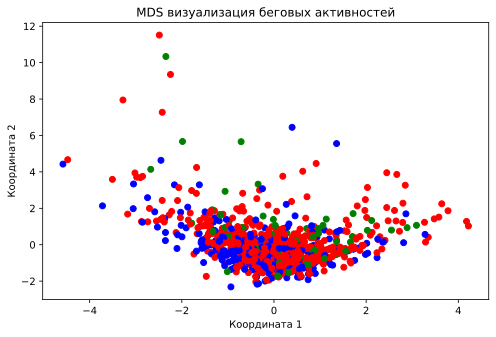

In [15]:
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=X['age_group'].map({'18 - 34': 'blue', '35 - 54': 'red', '55 +': 'green'}))
plt.title('MDS визуализация беговых активностей')
plt.xlabel('Координата 1')
plt.ylabel('Координата 2')
plt.show()

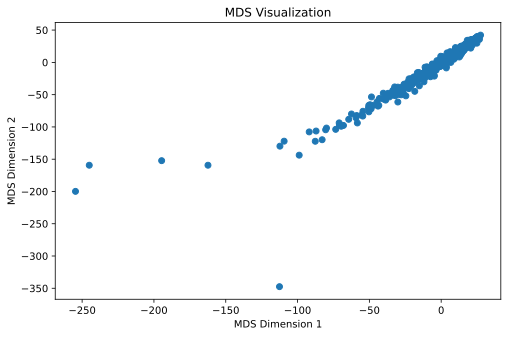

CPU times: user 57.7 s, sys: 8.02 s, total: 1min 5s
Wall time: 37.1 s


In [16]:
%%time
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS

# создание матрицы расстояний между объектами на основе расстояний Минковского
X = df[:1000][['distance','duration', 'pace']].values # выбор признаков для анализа
distances = pdist(X, metric='minkowski') # расчет расстояний Минковского
distance_matrix = squareform(distances) # преобразование расстояний в матрицу

mds = MDS(n_components=2, dissimilarity='precomputed')
X_mds = mds.fit_transform(distance_matrix)

plt.scatter(X_mds[:, 0], X_mds[:, 1])
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Visualization')
plt.show()

In [17]:
# СОЗДАЕМ список забегов, где дистанция > 40 км
more40 = df[(df['distance'] >= 40) & (df['distance'] <= 50)]
more40 = more40[['athlete', 'distance', 'duration', 'datetime', 'pace']]

# УДАЛЯЕМ записи где дата от 2019-01-01 до +3 месяца, чтоб можно было просчитать тренировки до
firstDay = pd.to_datetime('2019-03-31', format='%Y-%m-%d')
more40 = more40[more40['datetime'] > firstDay]

In [18]:
# УДАЛЯЕМ ненужные столбцы
more40 = more40[['athlete', 'datetime', 'pace']]

In [19]:
%%time

def fill_new_df(row):
    athlete = df.loc[df['athlete'] == row['athlete']]
    athlete = athlete.loc[(athlete['datetime'] >= row['datetime'] - pd.DateOffset(91)) & (athlete['datetime'] <= row['datetime'])]

    row['pace40'] = row['pace']
    row['gender'], row['country'], row['age_group'] = athlete[['gender', 'country', 'age_group']].iloc[0]
    row['distance_mean'] = athlete['distance'].mean() * 7
    row['pace_mean'] = athlete['pace'].mean()

    return row

result_df = more40.apply(fill_new_df, axis=1)

result_df

CPU times: user 19min 37s, sys: 1min 12s, total: 20min 49s
Wall time: 21min 46s


athlete   datetime    pace  pace40 gender         country age_group  \
211           223 2020-01-01 4.87633 4.87633      M           China   35 - 54   
260           275 2020-01-01 8.50211 8.50211      M   United States      55 +   
426           450 2020-01-01 9.62543 9.62543      M   United States   35 - 54   
988          1036 2020-01-01 6.85393 6.85393      M   United States   35 - 54   
1134         1188 2020-01-01 8.65171 8.65171      M   United States   35 - 54   
...           ...        ...     ...     ...    ...             ...       ...   
26616462    36850 2019-12-31 5.86470 5.86470      M         Germany   35 - 54   
26616541    36933 2019-12-31 4.26567 4.26567      M     Switzerland   18 - 34   
26616788    37190 2019-12-31 5.36737 5.36737      M         Denmark   35 - 54   
26616797    37199 2019-12-31 5.62747 5.62747      M     Switzerland   18 - 34   
26616834    37237 2019-12-31 5.28177 5.28177      M  United Kingdom   35 - 54   

          distance_mean  pace_mean  
211           140.03500    5.19597  
260           108.48536    6.83341  
426           118.75733    7.95317  
988            62.75890    6.12377  
1134          143.79235    6.70644  
...                 ...        ...  
26616462       93.23982    5.24576  
26616541      109.44003    4.64769  
26616788      127.87526    5.35171  
26616797      153.89301    6.53295  
26616834      102.98556    5.31041  

[66283 rows x 9 columns]

In [20]:
more40.head()

athlete   datetime    pace
211       223 2020-01-01 4.87633
260       275 2020-01-01 8.50211
426       450 2020-01-01 9.62543
988      1036 2020-01-01 6.85393
1134     1188 2020-01-01 8.65171

In [ ]:
# more40[['distance', 'country']].groupby('country').sum().plot(kind='bar', rot=45)

In [21]:
# ЗАМЕНЯЕМ значения в столбце gender М=>1, F=>0
result_df['gender'] = result_df['gender'].map({'M': 1, 'F': 0})

In [22]:
# ЗАМЕНЯЕМ значения в столбце age_group
result_df['age_group'] = result_df['age_group'].map({'18 - 34': 18, '35 - 54': 35, '55 +': 55})

In [23]:
# ПРЕОБРАЗОВАНИЕ категориальной переменной country в числовую
result_df = pd.get_dummies(result_df, columns=['country'])

In [24]:
# УДАЛЯЕМ ненужные столбцы athlete, datetime
df_model = result_df.drop(['athlete', 'datetime'], axis=1)

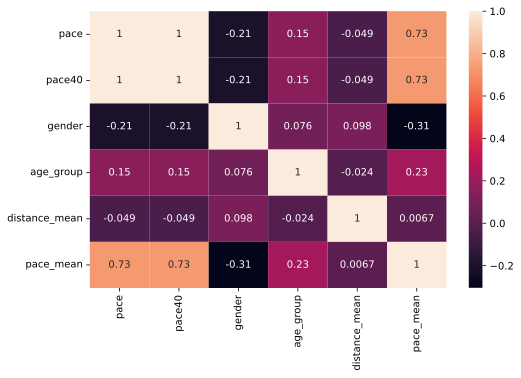

In [25]:
# какие признаки коррелируют
corr_matrix = result_df[['pace', 'pace40', 'gender', 'age_group', 'distance_mean', 'pace_mean']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [26]:
# РАЗДЕЛЕНИЕ на тренировочный и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('pace40', axis=1), df_model['pace40'], test_size=0.2, random_state=42)

In [27]:
%%time

# ВАРИАНТ №1, градиентный бустинг

params = {
    'learning_rate': 0.01,
    'n_estimators': 500,
    'max_depth': 6,
    'objective': 'reg:squarederror',
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.8,
    'reg_lambda': 0.1,
    'eval_metric': 'rmse',
    'random_state': 42
}

# обучение модели
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

# оценка качества модели на тестовом наборе данных
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 0.001464617682859687
CPU times: user 5min 11s, sys: 1.39 s, total: 5min 12s
Wall time: 1min 26s


In [28]:
# объединение тестовой выборки с исходным dataframe
df_predicted = pd.concat([X_test, y_test], axis=1)
df_predicted['predicted_pace'] = y_pred
df_predicted[['pace','gender','age_group','distance_mean','pace_mean','pace40',
       'predicted_pace']].head()

pace  gender  age_group  distance_mean  pace_mean  pace40  \
23707116 4.69874       1         35      118.36867    5.13934 4.69874   
24494338 6.23236       1         35      102.24846    6.66307 6.23236   
2420793  6.03027       1         18       84.94294    5.67437 6.03027   
9860285  6.44853       0         35       91.93579    6.41049 6.44853   
17597024 3.82989       1         18      114.72300    4.42936 3.82989   

          predicted_pace  
23707116         4.66981  
24494338         6.20994  
2420793          5.99173  
9860285          6.40772  
17597024         3.80979

In [29]:
df_predicted.columns

Index(['pace', 'gender', 'age_group', 'distance_mean', 'pace_mean',
       'country_Afghanistan', 'country_Andorra', 'country_Angola',
       'country_Argentina', 'country_Armenia',
       ...
       'country_United Arab Emirates', 'country_United Kingdom',
       'country_United States', 'country_Uruguay', 'country_Uzbekistan',
       'country_Venezuela', 'country_Vietnam', 'country_Zimbabwe', 'pace40',
       'predicted_pace'],
      dtype='object', length=119)

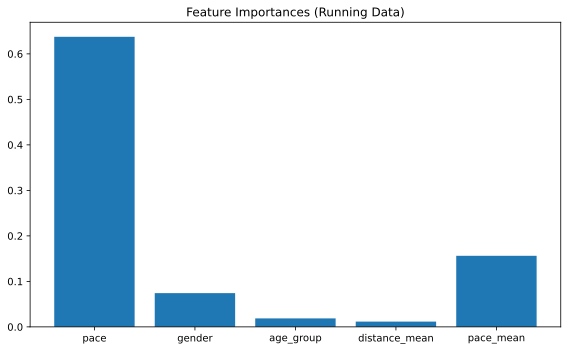

In [30]:
# Вывод важности признаков в виде графика
fig, ax = plt.subplots()
ax.bar(X_train.columns[:5], model.feature_importances_[:5])
ax.set_title("Feature Importances (Running Data)")
fig.tight_layout()
plt.show()

In [31]:
# ВАРИАНТ №2, ЛИНЕЙНАЯ РЕГРЕССИЯ
from sklearn.linear_model import LinearRegression
model_lrg = LinearRegression().fit(X_train, y_train)

y_pred = model_lrg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 8.393912634612661e-30


In [32]:
# ВАРИАНТ №3, НЕЙРОСЕТЬ

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

df_model = result_df[['distance_mean', 'pace_mean', 'pace40', 'gender', 'age_group']]
X = df_model.drop(["pace40"], axis=1) # выбор признаков
y = df_model["pace40"] # выбор целевого признака
scaler = StandardScaler() # инициализация стандартизатора
X = scaler.fit_transform(X) # нормализация признаков

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение архитектуры нейронной сети
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Оценка качества модели на тестовой выборке
loss, mae = model.evaluate(X_test, y_test)

print(loss)
print(mae)

2023-08-23 14:08:33.539057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 14:08:49.317675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1658/1658 [==============================] - 6s 3ms/step - loss: 1.7447 - mae: 0.8419 - val_loss: 0.7728 - val_mae: 0.6262
Epoch 2/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7920 - mae: 0.6381 - val_loss: 0.8051 - val_mae: 0.6679
Epoch 3/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7911 - mae: 0.6376 - val_loss: 0.8099 - val_mae: 0.6327
Epoch 4/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7889 - mae: 0.6369 - val_loss: 0.7687 - val_mae: 0.6271
Epoch 5/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7886 - mae: 0.6361 - val_loss: 0.7803 - val_mae: 0.6405
Epoch 6/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7871 - mae: 0.6358 - val_loss: 0.7674 - val_mae: 0.6300
Epoch 7/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7858 - mae: 0.6346 - val_loss: 0.7680 - val_mae: 0.6323
Epoch 8/100
1658/1658 [==============================] 

1658/1658 [==============================] - 4s 2ms/step - loss: 0.7760 - mae: 0.6291 - val_loss: 0.7658 - val_mae: 0.6178
Epoch 62/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7772 - mae: 0.6298 - val_loss: 0.7843 - val_mae: 0.6522
Epoch 63/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7760 - mae: 0.6293 - val_loss: 0.7692 - val_mae: 0.6190
Epoch 64/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7756 - mae: 0.6292 - val_loss: 0.7647 - val_mae: 0.6328
Epoch 65/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7762 - mae: 0.6293 - val_loss: 0.7615 - val_mae: 0.6256
Epoch 66/100
1658/1658 [==============================] - 4s 2ms/step - loss: 0.7770 - mae: 0.6294 - val_loss: 0.7649 - val_mae: 0.6223
Epoch 67/100
1658/1658 [==============================] - 4s 3ms/step - loss: 0.7760 - mae: 0.6295 - val_loss: 0.7659 - val_mae: 0.6230
Epoch 68/100
1658/1658 [==============================] - 4s 

In [33]:
# ВАРИАНТ №4, СЛУЧАЙНЫЙ ЛЕС

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Предобработка данных
X = result_df[['distance_mean', 'pace_mean', 'gender', 'age_group']]
y = result_df['pace40']
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели случайного леса
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Оценка качества модели
score = rf.score(X_test, y_test)
print('R^2 score: ', score)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

R^2 score:  0.5424358933875926
MSE: 0.766651207562913


In [34]:
# Предсказание темпа бега на дистанции свыше 42 км для новых данных
new_data = pd.DataFrame({'distance_mean': [50], 'pace_mean': [6.5], 'gender': [1],
                         'age_group': [18]})
new_data = scaler.transform(new_data)
prediction = rf.predict(new_data)
print(prediction)

[7.23112949]


In [ ]:
#sns_plot = sns.pairplot(df['distance', 'duration', 'age_group', 'pace'])

In [35]:
# ВАРИАНТ №5, Деревья решений 
from sklearn import tree

X = result_df[['distance_mean', 'pace_mean', 'gender', 'age_group']]
y = result_df['pace40']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = tree.DecisionTreeRegressor(max_depth=3, random_state=42)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 0.8013119202855135


In [36]:
# объединение тестовой выборки с исходным dataframe
df_pred = pd.concat([X_test, y_test], axis=1)
df_pred['predicted_pace'] = y_pred
df_pred.head()

distance_mean  pace_mean  gender  age_group  pace40  predicted_pace
23707116      118.36867    5.13934       1         35 4.69874         5.30275
24494338      102.24846    6.66307       1         35 6.23236         7.26455
2420793        84.94294    5.67437       1         18 6.03027         5.72631
9860285        91.93579    6.41049       0         35 6.44853         6.58971
17597024      114.72300    4.42936       1         18 3.82989         4.32987

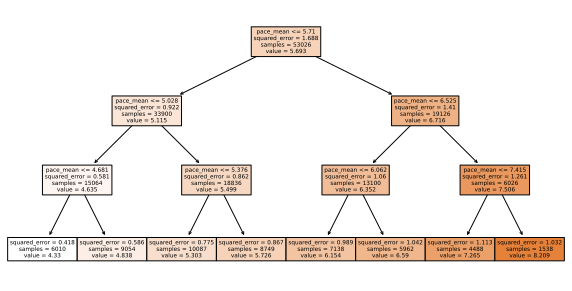

In [37]:
fig = plt.figure(figsize=(10,5))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,
                   class_names=['pace40'],
                   filled=True)

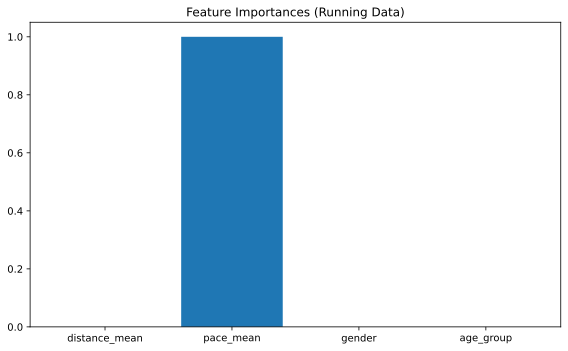

In [38]:
# Вывод важности признаков в виде графика
fig, ax = plt.subplots()
ax.bar(X.columns, clf.feature_importances_)
ax.set_title("Feature Importances (Running Data)")
fig.tight_layout()
plt.show()

In [39]:
clf.feature_importances_

array([0., 1., 0., 0.])